In [1]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 905.3/905.3 kB 16.1 MB/s eta 0:00:00


In [2]:
import os
import glob
import cv2
import torch
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ultralytics import YOLO 

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
train_path = "/kaggle/input/traffic-detection-project/train"
valid_path = "/kaggle/input/traffic-detection-project/valid"
test_path = "/kaggle/input/traffic-detection-project/test"
data_yaml = "/kaggle/input/traffic-detection-project/data.yaml"

In [4]:
os.makedirs("/kaggle/working", exist_ok=True)



🔍 **Dataset Analysis Started...**

📂 **Dataset Structure:**
🔹 Train images: 5805
🔹 Valid images: 549
🔹 Test images: 279


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


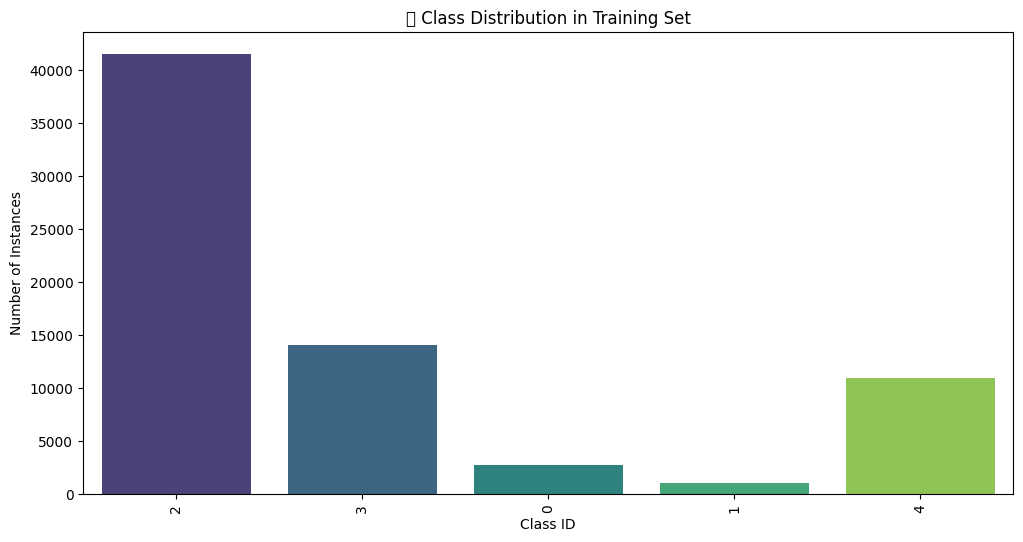

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128207 (\N{STRAIGHT RULER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


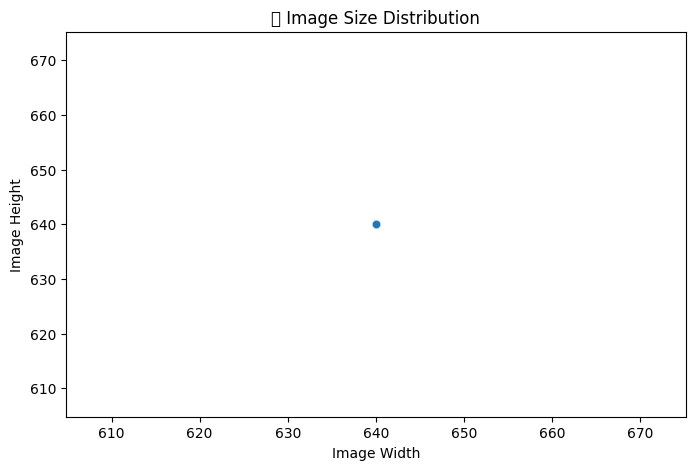

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


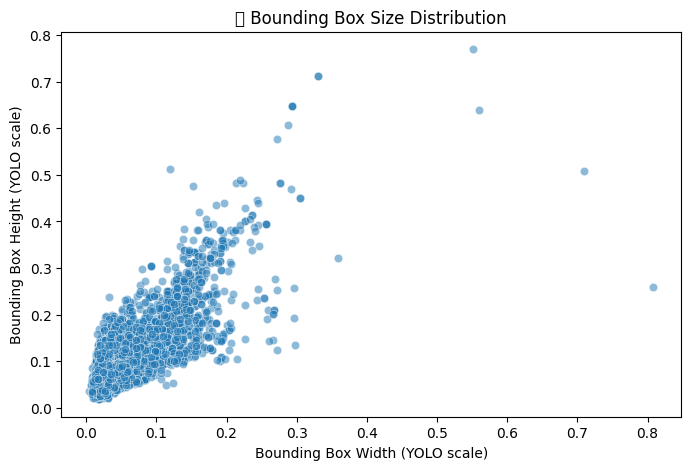

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


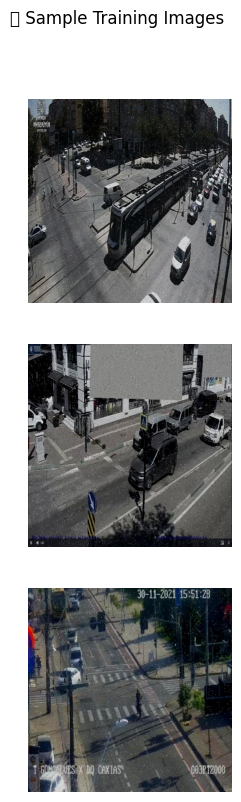


✅ **Dataset Analysis Complete!**


In [5]:
def analyze_dataset():
    print("\n🔍 **Dataset Analysis Started...**")
    
    # Count images in train, valid, test
    train_images = glob.glob(os.path.join(train_path, "images", "*.jpg"))
    valid_images = glob.glob(os.path.join(valid_path, "images", "*.jpg"))
    test_images = glob.glob(os.path.join(test_path, "images", "*.jpg"))

    print(f"\n📂 **Dataset Structure:**")
    print(f"🔹 Train images: {len(train_images)}")
    print(f"🔹 Valid images: {len(valid_images)}")
    print(f"🔹 Test images: {len(test_images)}")

    # Class distribution analysis
    train_labels = glob.glob(os.path.join(train_path, "labels", "*.txt"))

    class_counts = {}

    for label_file in train_labels:
        with open(label_file, "r") as f:
            for line in f:
                class_id = line.split()[0]  # First column is class ID
                class_counts[class_id] = class_counts.get(class_id, 0) + 1

    # Plot class distribution
    plt.figure(figsize=(12, 6))
    sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette="viridis")
    plt.xlabel("Class ID")
    plt.ylabel("Number of Instances")
    plt.title("🔍 Class Distribution in Training Set")
    plt.xticks(rotation=90)
    plt.show()

    # Image size analysis
    img_sizes = []
    for img_path in train_images[:500]:  # Check first 500 images for efficiency
        img = cv2.imread(img_path)
        if img is not None:
            img_sizes.append((img.shape[1], img.shape[0]))  # (width, height)

    img_sizes_df = pd.DataFrame(img_sizes, columns=["Width", "Height"])
    plt.figure(figsize=(8, 5))
    sns.scatterplot(data=img_sizes_df, x="Width", y="Height", alpha=0.5)
    plt.xlabel("Image Width")
    plt.ylabel("Image Height")
    plt.title("📏 Image Size Distribution")
    plt.show()

    # Bounding box size analysis
    bbox_sizes = []
    for label_file in train_labels[:500]:  # First 500 for efficiency
        with open(label_file, "r") as f:
            for line in f:
                parts = line.split()
                w, h = float(parts[3]), float(parts[4])  # YOLO format [x_center, y_center, width, height]
                bbox_sizes.append((w, h))

    bbox_df = pd.DataFrame(bbox_sizes, columns=["Width", "Height"])
    plt.figure(figsize=(8, 5))
    sns.scatterplot(data=bbox_df, x="Width", y="Height", alpha=0.5)
    plt.xlabel("Bounding Box Width (YOLO scale)")
    plt.ylabel("Bounding Box Height (YOLO scale)")
    plt.title("📦 Bounding Box Size Distribution")
    plt.show()

    # Display sample images with bounding boxes
    def plot_sample_images(num_samples=3):
        sample_images = np.random.choice(train_images, num_samples, replace=False)
        plt.figure(figsize=(10, num_samples * 3))
        for i, img_path in enumerate(sample_images):
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.subplot(num_samples, 1, i + 1)
            plt.imshow(img)
            plt.axis("off")
        plt.suptitle("🔍 Sample Training Images")
        plt.show()

    plot_sample_images()

    print("\n✅ **Dataset Analysis Complete!**")
analyze_dataset()

In [6]:
def train_yolo_v8(epochs=50, batch_size=8, learning_rate=0.01, img_size=640):
    # Load YOLOv8 model
    model = YOLO("yolov8n.pt")  # Load pre-trained YOLOv8 model
    model.to('cuda' if torch.cuda.is_available() else 'cpu')

    # Path to data.yaml
    data_yaml = "/kaggle/input/traffic-detection-project/data.yaml"

    # Train the model using the correct arguments
    model.train(
        data=data_yaml,       # Specify the dataset
        imgsz=img_size,       # Image size
        batch=batch_size,     # Batch size
        epochs=epochs,        # Number of training epochs
        lr0=learning_rate,    # Learning rate
        name="yolov8custom_model_traffic"
    )

    # Save the trained model in Kaggle working directory
    export_path = "/kaggle/working/yolov8_trained.onnx"  # Define export path

    # Export the model in ONNX format
    model.export(format='onnx', imgsz=640)  # This will automatically save the file in the current directory, or you can define a path in the command
    



    print(f"Training complete. Model saved at: {export_path}")

In [7]:
if __name__ == "__main__":
    train_yolo_v8()

100%|██████████| 6.25M/6.25M [00:00<00:00, 87.2MB/s]


engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/input/traffic-detection-project/data.yaml, epochs=50, time=None, patience=100, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=cuda:0, workers=8, project=None, name=yolov8custom_model_traffic, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format=torchs

100%|██████████| 755k/755k [00:00<00:00, 18.0MB/s]


Overriding model.yaml nc=80 with nc=5

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 75.2MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/input/traffic-detection-project/train/labels... 5805 images, 93 backgrounds, 0 corrupt: 100%|██████████| 5805/5805 [00:17<00:00, 328.82it/s]


train: WARNING ⚠️ Cache directory /kaggle/input/traffic-detection-project/train is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.24 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/input/traffic-detection-project/valid/labels... 549 images, 8 backgrounds, 0 corrupt: 100%|██████████| 549/549 [00:03<00:00, 178.26it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/traffic-detection-project/valid is not writeable, cache not saved.


Plotting labels to runs/detect/yolov8custom_model_traffic/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/yolov8custom_model_traffic
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      1.73G      1.409      1.591      1.112         47        640: 100%|██████████| 726/726 [01:17<00:00,  9.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:05<00:00,  6.37it/s]


                   all        549       6270      0.703      0.633      0.687      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      1.74G      1.292      1.047      1.059         41        640: 100%|██████████| 726/726 [01:13<00:00,  9.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:03<00:00,  9.39it/s]


                   all        549       6270      0.769      0.652       0.72      0.471

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      1.42G      1.263     0.9549      1.049         31        640: 100%|██████████| 726/726 [01:12<00:00, 10.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:03<00:00,  9.49it/s]


                   all        549       6270       0.78      0.719      0.782      0.516

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      1.48G      1.234     0.8894      1.036        138        640: 100%|██████████| 726/726 [01:12<00:00, 10.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:03<00:00,  9.33it/s]


                   all        549       6270      0.786      0.729       0.79      0.527

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      1.61G      1.216     0.8442      1.027         78        640: 100%|██████████| 726/726 [01:12<00:00, 10.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:03<00:00,  9.39it/s]


                   all        549       6270      0.759      0.737      0.799      0.537

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50       1.6G      1.188     0.8098      1.017        108        640: 100%|██████████| 726/726 [01:11<00:00, 10.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:03<00:00,  9.62it/s]


                   all        549       6270      0.769      0.727       0.78      0.532

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      1.63G      1.176     0.7796      1.011         66        640: 100%|██████████| 726/726 [01:12<00:00, 10.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:03<00:00,  9.44it/s]


                   all        549       6270      0.797      0.773      0.824      0.556

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      1.74G      1.167     0.7628      1.008        127        640: 100%|██████████| 726/726 [01:12<00:00, 10.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:03<00:00,  9.44it/s]


                   all        549       6270      0.814      0.755      0.832      0.574

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      1.92G      1.151     0.7478     0.9996        183        640: 100%|██████████| 726/726 [01:12<00:00, 10.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:03<00:00,  9.03it/s]


                   all        549       6270      0.805      0.786       0.84      0.576

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      1.64G      1.135     0.7356     0.9949         32        640: 100%|██████████| 726/726 [01:12<00:00,  9.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:03<00:00,  9.58it/s]


                   all        549       6270      0.835       0.78      0.851      0.585

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50       1.7G      1.127     0.7193     0.9924         62        640: 100%|██████████| 726/726 [01:11<00:00, 10.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:03<00:00,  9.64it/s]

                   all        549       6270      0.841      0.786      0.845       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      1.56G      1.108     0.6998     0.9841         79        640: 100%|██████████| 726/726 [01:12<00:00, 10.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:03<00:00,  9.57it/s]


                   all        549       6270      0.831      0.755      0.841      0.586

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      1.72G      1.109     0.6971     0.9813         68        640: 100%|██████████| 726/726 [01:12<00:00, 10.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:03<00:00,  9.66it/s]

                   all        549       6270      0.849      0.797      0.861      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      1.72G      1.101       0.69     0.9821         59        640: 100%|██████████| 726/726 [01:11<00:00, 10.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:03<00:00,  9.72it/s]


                   all        549       6270      0.866      0.807      0.875      0.611

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      1.59G      1.091     0.6804     0.9767         67        640: 100%|██████████| 726/726 [01:11<00:00, 10.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:03<00:00,  9.76it/s]


                   all        549       6270      0.862      0.807      0.867      0.611

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      1.55G      1.084     0.6742     0.9745         74        640: 100%|██████████| 726/726 [01:11<00:00, 10.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:03<00:00,  9.51it/s]

                   all        549       6270      0.814      0.809      0.868      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      1.78G      1.077     0.6649     0.9732        100        640: 100%|██████████| 726/726 [01:11<00:00, 10.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:03<00:00,  9.65it/s]


                   all        549       6270      0.854      0.821      0.873      0.621

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      1.77G      1.067      0.653     0.9656         87        640: 100%|██████████| 726/726 [01:11<00:00, 10.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:03<00:00,  9.51it/s]

                   all        549       6270      0.874      0.803      0.877      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      1.76G      1.055     0.6474      0.968        129        640: 100%|██████████| 726/726 [01:11<00:00, 10.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:03<00:00,  9.81it/s]

                   all        549       6270      0.868       0.83      0.884      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50       1.7G      1.051     0.6393     0.9652         85        640: 100%|██████████| 726/726 [01:11<00:00, 10.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:03<00:00,  9.53it/s]

                   all        549       6270      0.861      0.832      0.885      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      1.83G      1.044     0.6323     0.9609         67        640: 100%|██████████| 726/726 [01:11<00:00, 10.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:03<00:00,  9.44it/s]

                   all        549       6270      0.842      0.829       0.89      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      1.59G      1.031     0.6245      0.956         77        640: 100%|██████████| 726/726 [01:11<00:00, 10.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:03<00:00,  8.91it/s]


                   all        549       6270      0.865      0.838      0.894      0.644

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      1.78G       1.03     0.6205     0.9552         75        640: 100%|██████████| 726/726 [01:15<00:00,  9.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:03<00:00,  9.18it/s]

                   all        549       6270      0.872      0.831      0.895      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      1.74G      1.026     0.6165     0.9554         74        640: 100%|██████████| 726/726 [01:16<00:00,  9.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:03<00:00,  8.97it/s]


                   all        549       6270      0.877      0.833      0.893      0.646

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      1.38G      1.016     0.6069     0.9509         68        640: 100%|██████████| 726/726 [01:14<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:03<00:00,  9.88it/s]


                   all        549       6270      0.885      0.829      0.897      0.649

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      1.98G      1.006     0.6021     0.9483         86        640: 100%|██████████| 726/726 [01:13<00:00,  9.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:03<00:00,  9.47it/s]


                   all        549       6270       0.86      0.858      0.905      0.661

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      1.55G      1.002     0.5964     0.9478         59        640: 100%|██████████| 726/726 [01:15<00:00,  9.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:04<00:00,  8.75it/s]


                   all        549       6270      0.879       0.84      0.901      0.659

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      1.51G     0.9989     0.5925     0.9439         79        640: 100%|██████████| 726/726 [01:15<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:03<00:00,  9.57it/s]

                   all        549       6270      0.867      0.858      0.907      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      1.97G     0.9872      0.586     0.9406         63        640: 100%|██████████| 726/726 [01:14<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:03<00:00,  8.81it/s]

                   all        549       6270      0.877      0.848      0.908      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      1.57G     0.9825     0.5819     0.9389         92        640: 100%|██████████| 726/726 [01:15<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:03<00:00,  9.48it/s]

                   all        549       6270      0.897      0.852       0.91       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      1.59G     0.9779     0.5766     0.9366        125        640: 100%|██████████| 726/726 [01:14<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:03<00:00,  9.30it/s]


                   all        549       6270      0.895       0.85      0.911      0.671

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      1.74G     0.9689     0.5697      0.935        176        640: 100%|██████████| 726/726 [01:14<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:03<00:00,  8.94it/s]

                   all        549       6270      0.892      0.857       0.91      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      1.61G     0.9652     0.5675     0.9346         30        640: 100%|██████████| 726/726 [01:14<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:03<00:00,  9.50it/s]

                   all        549       6270      0.892      0.849      0.911      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      1.73G     0.9575     0.5627     0.9327         52        640: 100%|██████████| 726/726 [01:15<00:00,  9.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:03<00:00,  9.30it/s]


                   all        549       6270      0.881      0.861      0.912      0.677

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      1.64G     0.9571      0.558     0.9308         85        640: 100%|██████████| 726/726 [01:15<00:00,  9.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:03<00:00,  9.10it/s]

                   all        549       6270      0.892      0.845      0.913      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      1.67G     0.9572      0.557     0.9317         90        640: 100%|██████████| 726/726 [01:14<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:03<00:00,  9.18it/s]


                   all        549       6270      0.902      0.862      0.921      0.683

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      1.61G     0.9405     0.5478     0.9278         86        640: 100%|██████████| 726/726 [01:15<00:00,  9.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:03<00:00,  8.91it/s]


                   all        549       6270      0.888      0.863      0.918      0.687

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      1.88G     0.9377     0.5437      0.927         72        640: 100%|██████████| 726/726 [01:16<00:00,  9.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:03<00:00,  9.14it/s]

                   all        549       6270      0.895      0.859      0.917      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      1.47G     0.9391     0.5444     0.9242        125        640: 100%|██████████| 726/726 [01:15<00:00,  9.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:03<00:00,  9.55it/s]

                   all        549       6270      0.895      0.861      0.919       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      1.68G     0.9295     0.5407     0.9241        105        640: 100%|██████████| 726/726 [01:15<00:00,  9.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:03<00:00,  9.24it/s]

                   all        549       6270      0.902       0.86      0.921      0.693


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      1.31G      0.895     0.5005     0.9159         35        640: 100%|██████████| 726/726 [01:14<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:04<00:00,  8.68it/s]


                   all        549       6270        0.9      0.865      0.922      0.696

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      1.32G      0.881     0.4918     0.9116         55        640: 100%|██████████| 726/726 [01:13<00:00,  9.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:03<00:00,  8.95it/s]

                   all        549       6270      0.906      0.863      0.923      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      1.29G     0.8718     0.4847     0.9078         22        640: 100%|██████████| 726/726 [01:13<00:00,  9.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:03<00:00,  9.40it/s]

                   all        549       6270      0.907      0.865      0.924      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      1.31G     0.8615     0.4793     0.9067         32        640: 100%|██████████| 726/726 [01:13<00:00,  9.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:03<00:00,  9.22it/s]

                   all        549       6270       0.89       0.88      0.924      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50       1.3G     0.8581     0.4764      0.904         27        640: 100%|██████████| 726/726 [01:13<00:00,  9.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:03<00:00,  9.12it/s]


                   all        549       6270      0.903      0.871      0.925      0.704

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      1.26G     0.8482     0.4685      0.901         57        640: 100%|██████████| 726/726 [01:12<00:00,  9.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:03<00:00,  9.39it/s]

                   all        549       6270      0.889      0.884      0.925      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      1.31G     0.8435     0.4643     0.9007         37        640: 100%|██████████| 726/726 [01:12<00:00,  9.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:03<00:00,  9.00it/s]


                   all        549       6270      0.904      0.871      0.926      0.706

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50       1.3G     0.8376     0.4608     0.8983         62        640: 100%|██████████| 726/726 [01:13<00:00,  9.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:03<00:00,  9.16it/s]

                   all        549       6270      0.905      0.878      0.927      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      1.31G     0.8316     0.4567     0.8954         61        640: 100%|██████████| 726/726 [01:13<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:03<00:00,  9.30it/s]

                   all        549       6270      0.905       0.88      0.927      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      1.32G      0.828     0.4538     0.8955         40        640: 100%|██████████| 726/726 [01:14<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:03<00:00,  9.05it/s]


                   all        549       6270      0.903      0.879      0.929       0.71

50 epochs completed in 1.086 hours.
Optimizer stripped from runs/detect/yolov8custom_model_traffic/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/yolov8custom_model_traffic/weights/best.pt, 6.3MB

Validating runs/detect/yolov8custom_model_traffic/weights/best.pt...
Ultralytics 8.3.58 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 168 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:07<00:00,  4.72it/s]


                   all        549       6270      0.904      0.879      0.929      0.711
               bicycle        189        250      0.913       0.92      0.935      0.762
                   bus         81        108      0.926      0.926      0.974      0.873
                   car        520       3842      0.921      0.932      0.968      0.777
             motorbike        331       1238      0.909      0.805       0.89       0.58
                person        196        832      0.852       0.81      0.879      0.562
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to runs/detect/yolov8custom_model_traffic
Ultralytics 8.3.58 🚀 Python-3.10.12 torch-2.4.1+cu121 CPU (Intel Xeon 2.00GHz)
Model summary (fused): 168 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs

PyTorch: starting from 'runs/detect/yolov8custom_model_traffic/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 9, 8400) (6.0 MB)
requir

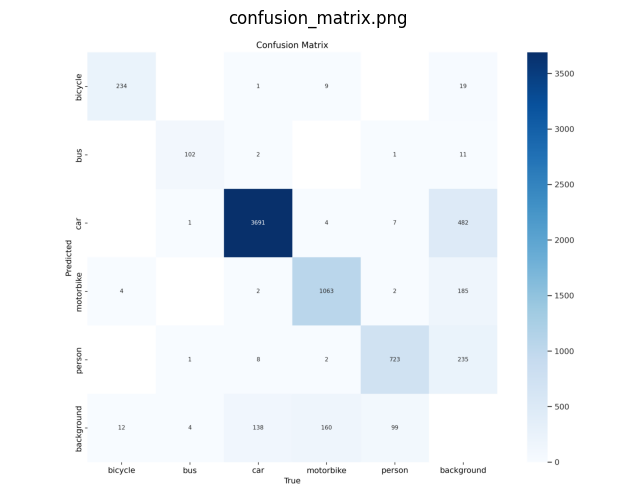

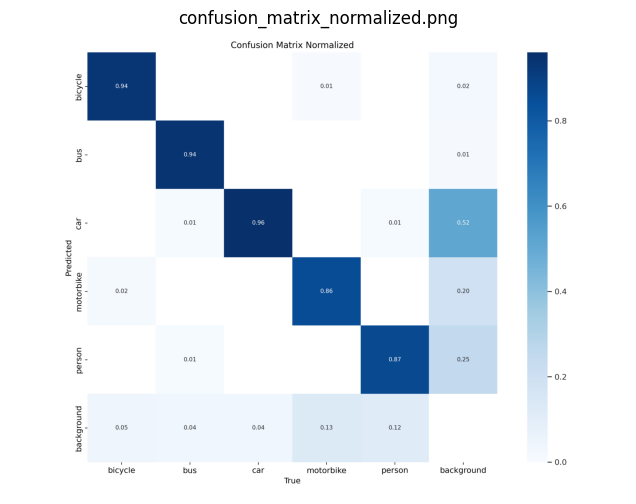

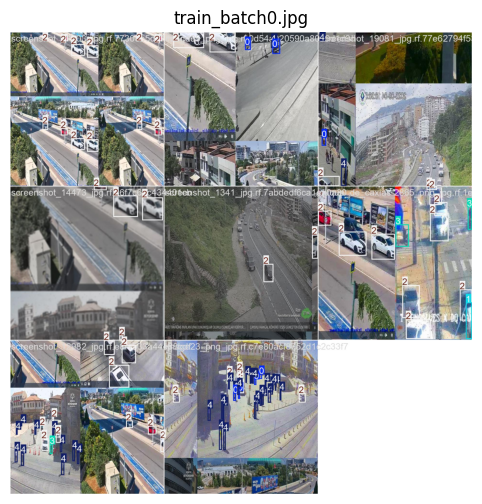

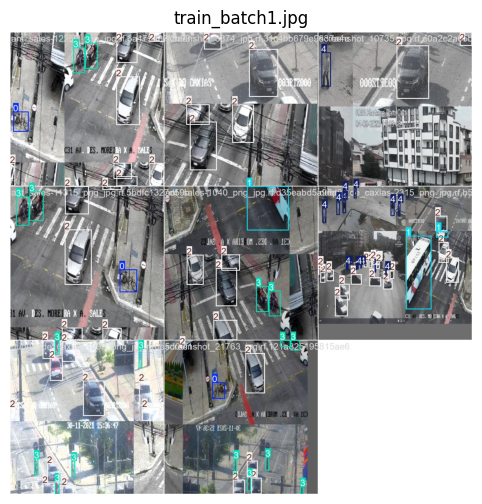

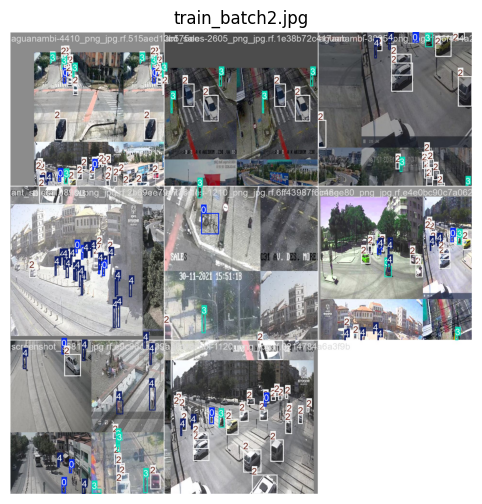

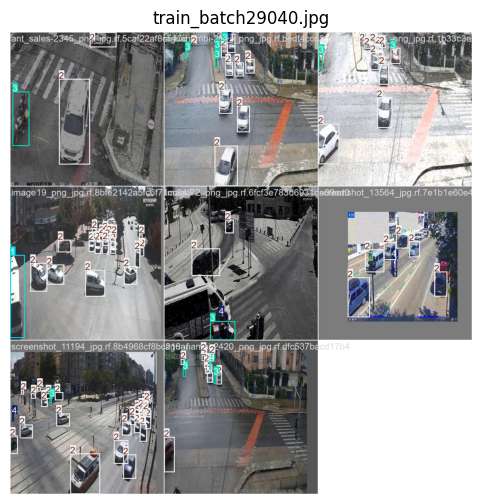

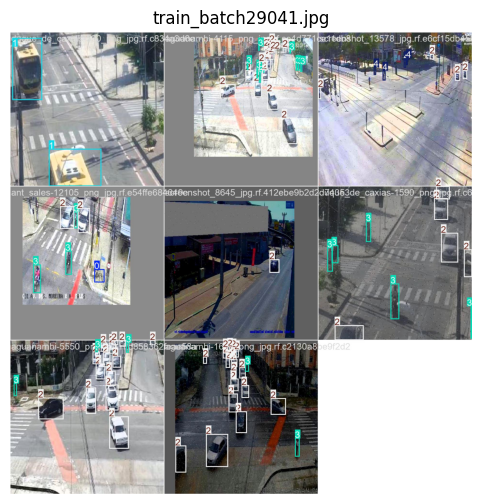

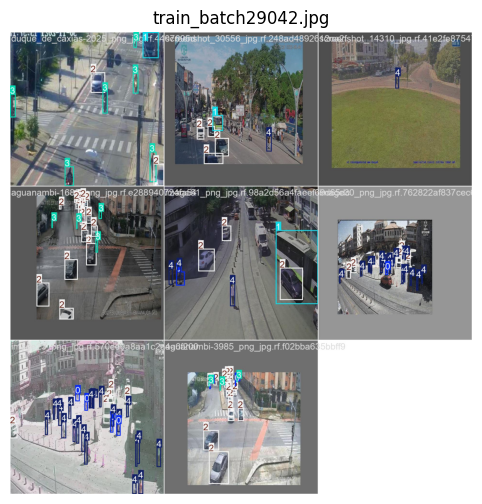

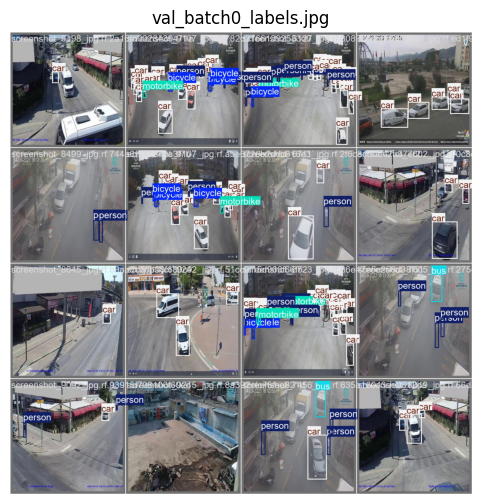

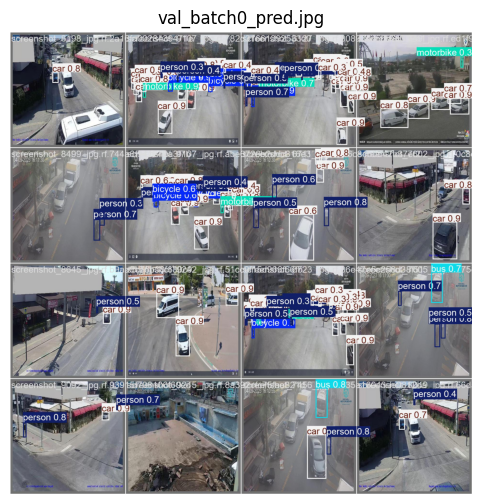

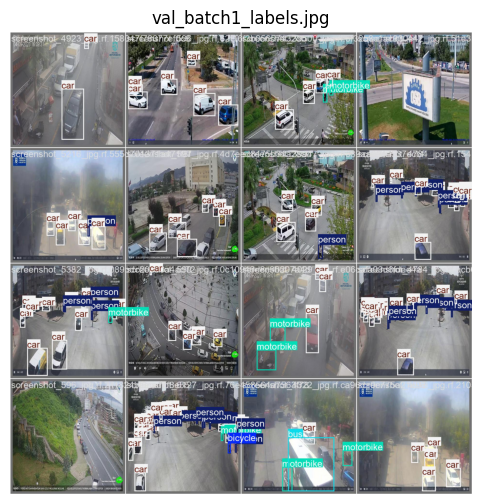

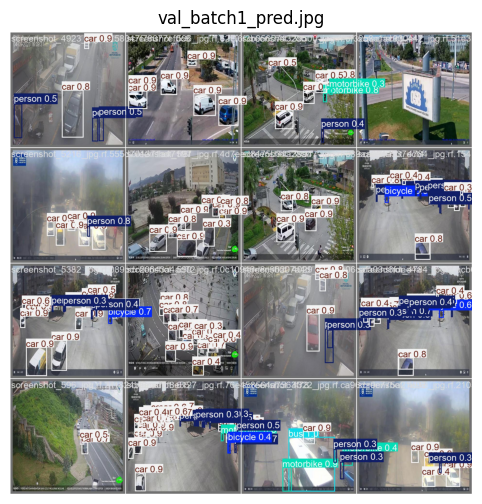

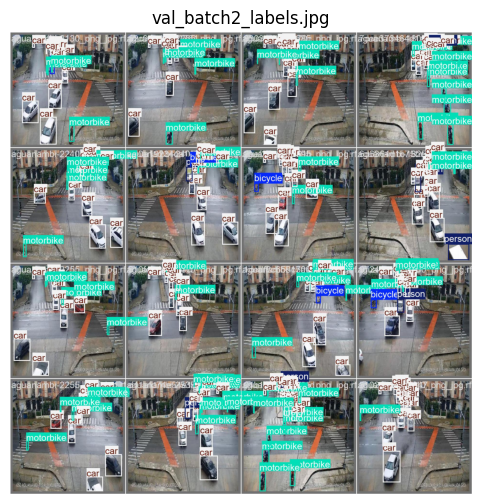

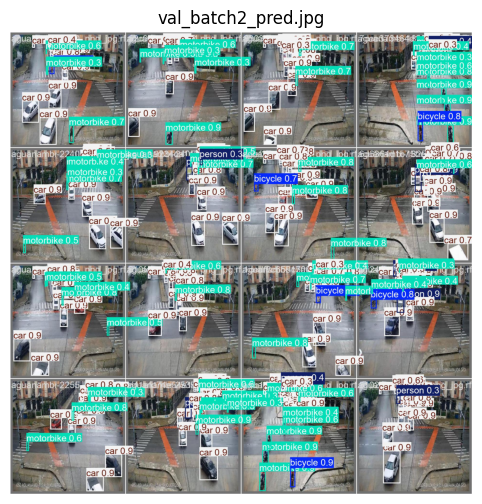

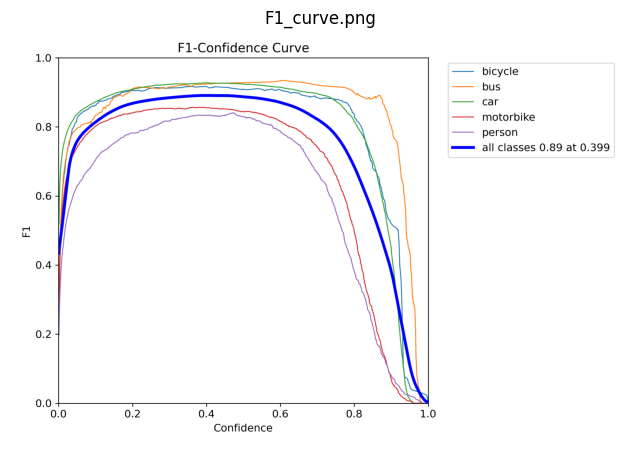

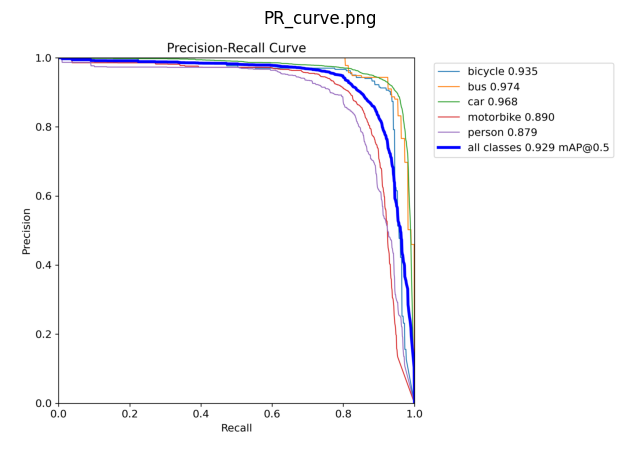

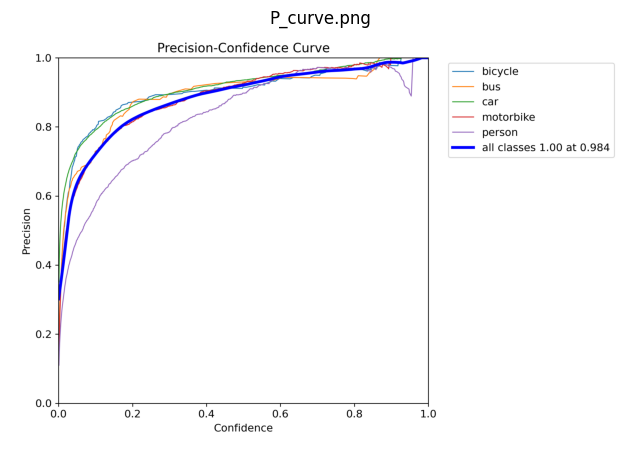

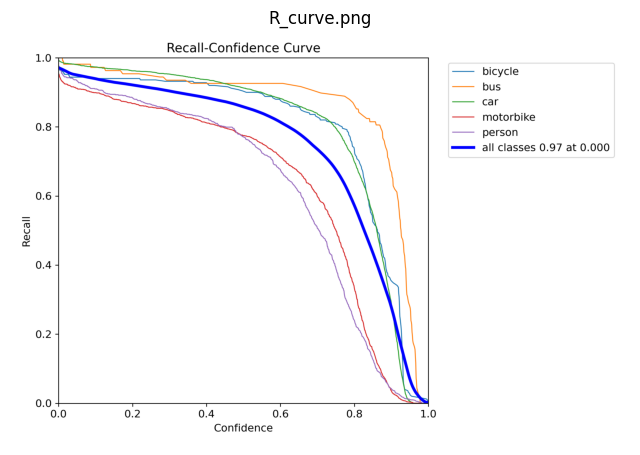

In [8]:
import cv2
import matplotlib.pyplot as plt
import os

# Provide your paths here
image_directory = '/kaggle/working/runs/detect/yolov8custom_model_traffic'

# List of specific image files to display (you can update this with your actual file names)
image_files = [
    'confusion_matrix.png', 
    'confusion_matrix_normalized.png', 
    'train_batch0.jpg', 
    'train_batch1.jpg', 
    'train_batch2.jpg', 
    'train_batch29040.jpg', 
    'train_batch29041.jpg', 
    'train_batch29042.jpg', 
    'val_batch0_labels.jpg', 
    'val_batch0_pred.jpg',
    'val_batch1_labels.jpg', 
    'val_batch1_pred.jpg', 
    'val_batch2_labels.jpg', 
    'val_batch2_pred.jpg',
    'F1_curve.png', 
    'PR_curve.png', 
    'P_curve.png', 
    'R_curve.png'
]

# Function to display images from the given path
def display_images(images, directory):
    for image_file in images:
        img_path = os.path.join(directory, image_file)
        if os.path.exists(img_path):
            img = cv2.imread(img_path)
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
            plt.figure(figsize=(8, 6))
            plt.imshow(img_rgb)
            plt.title(image_file)
            plt.axis('off')
            plt.show()
        else:
            print(f"Image not found: {img_path}")

# Display the images
display_images(image_files, image_directory)


In [9]:
yolov8custom_model_traffic

NameError: name 'yolov8custom_model_traffic' is not defined